# 5 Training ML models with Serotiny
This notebook shows how to
-  5.1 load libraries, predefined functions and the main dataset 
-  5.2 parametrize a ML task using serotiny's yamls 
-  5.3 train a classification model based on 2D images
-  5.4 load a pretrained model
-  5.4 train a classification model based on 3D images

#### Resources 
- Serotiny code: https://github.com/AllenCell/serotiny
- Serotiny documentation: https://allencell.github.io/serotiny
- Hydra for configurability https://hydra.cc/
- MLFlow for experiment tracking https://mlflow.org/
- Pytorch Lightning for DL training/testing/predictions https://pytorchlightning.ai/

## 5.1 Load libraries, predefine some functions, and load the manifest 


### Load libraries and predefined functions

In [111]:
# First "pip install -e ." from command line (when in cytodata-hackathon-base)

import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("bfio.backends").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)

from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image

### Load the manifest and explore dimensions

In [112]:
cells_df = pd.read_parquet("s3://variance-dataset/processed/manifest.parquet")
print(f'Number of cells: {len(cells_df)}')
print(f'Number of columns: {len(cells_df.columns)}')

Number of cells: 215081
Number of columns: 1242


## 5.2 Parametrize a ML task using serotiny's yamls

`serotiny` is a Python package and framework to help you create configurable and reproducible DL projects. It uses [hydra](https://hydra.cc/) for configurability, [MLFlow](https://mlflow.org/) for experiment tracking,
and [Pytorch Lightning](https://pytorchlightning.ai/) for DL model training/testing/predictions.

### Project structure
With `serotiny` a DL project has a predefined structure (which this repo already complies with). To start a new project with the appropriate structure, you can use the [serotiny-project cookiecutter](https://github.com/allencellmodeling/serotiny-project-cookiecutter)

A serotiny project contains a Python package, and a config folder. This config folder is composed of 5 config groups:
- `data` : where we configure access to datasets
- `model` : where we define and parameterize models/networks
- `trainer` : where we setup the Pytorch Lightning trainer
- `trainer/callbacks` : where we (optionally) add a list of callbacks to be run in train/test/prediction
- `mlflow`: where we configure access to a MLFlow server, where our experiments and results will be tracked and stored

<img src="resources/serotiny.png" width="800"/>

### `serotiny` commands
Aside from the predefined structure and config folder, `serotiny` has set of commands which know how to read a project's configuration (and override it)
and execute DL tasks.

For example, we could train a model using the a model config called `my_classifier` (which would live in `config/model/my_classifier.yaml`), and a data config
called `my_train_data` (which would live in `config/data/my_train_data.yaml`) and overriding some of the `mlflow` config parameters.
<br><small>Note: Because we didn't specify a top-level `mlflow` config, i.e. we didn't do `mlflow=...`, `serotiny` will use the default config, which lives in `config/mlflow/default.yaml`</small>

```
$ serotiny train model=my_classifier data=my_train_data mlflow.experiment_name=some_experiment mlflow.run_name=1st_run
```

Once the model finishes training, we could use it to make predictions on a different dataset, configured in `my_predict_data`

```
$ serotiny predict model=my_classifier data=my_predict_data mlflow.experiment_name=some_experiment mlflow.run_name=1st_run
```


## 5.3 Train a classification model based on 2D images


### Make a simple dataset of edge vs. non-edge cells

In [113]:
from serotiny.transforms.dataframe.transforms import split_dataframe

Path("/home/aicsuser/serotiny_data/").mkdir(parents=True, exist_ok=True)

n = 1000 # number of cells per class
cells_edgeVSnoedge = cells_df.groupby("edge_flag").sample(n)

# Add the train, test and validate split
cells_edgeVSnoedge = split_dataframe(dataframe=cells_edgeVSnoedge, train_frac=0.7, val_frac=0.2, return_splits=False)

cells_edgeVSnoedge.to_csv("/home/aicsuser/serotiny_data/cells_edgeVSnoedge.csv") 
print(f"Number of cells: {len(cells_edgeVSnoedge)}")
print(f"Number of columns: {len(cells_edgeVSnoedge.columns)}")

Number of cells: 2000
Number of columns: 1243


### Visualize some non-edge cell

In [114]:
some_cell = cells_edgeVSnoedge[cells_edgeVSnoedge.edge_flag == 0].sample(1).iloc[0]

img = image_loader(
    some_cell.registered_path,
    transform=rescale_image,
    return_as_torch=False
)

img.shape

(7, 136, 245, 381)

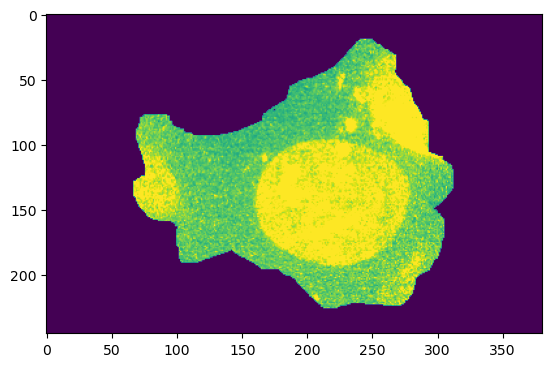

In [115]:
plt.imshow(img[1].max(axis=0))
plt.show()

### Visualize some edge cell

In [116]:
some_cell = cells_edgeVSnoedge[cells_edgeVSnoedge.edge_flag == 1].sample(1).iloc[0]

img = image_loader(
    some_cell.registered_path,
    transform=rescale_image,
    return_as_torch=False
)

img.shape

(7, 136, 245, 381)

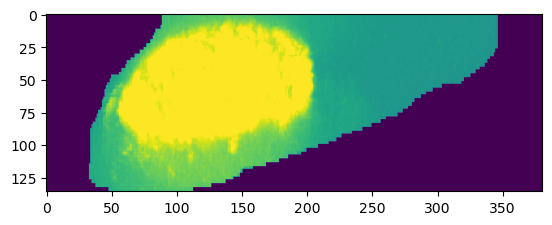

In [117]:
plt.imshow(img[1].max(axis=1))
plt.show()

In [118]:
some_cell[[col for col in some_cell.index if "fits" in col]]

fits_z    False
fits_y     True
fits_x     True
Name: 212540, dtype: object

### Configuring serotiny

As refered to above, `serotiny` requires you to have configured 5 modules. 
**TODO** general blurp about config syntax

#### `data` config

**TODO** Incrementally build up this yaml here in the markdown

```
_target_: serotiny.datamodules.ManifestDatamodule

path: /home/aicsuser/serotiny_data/cells_edgeVSnoedge.csv

batch_size: 64
num_workers: 1
loaders:
  id:
    _target_: serotiny.io.dataframe.loaders.LoadColumn
    column: CellId
    dtype: int
  class:
    _target_: serotiny.io.dataframe.loaders.LoadColumn
    column: edge_flag
    dtype: float32
  image:
    _target_: serotiny.io.dataframe.loaders.LoadImage
    column: max_projection_z
    select_channels: ['membrane']  
    
split_column: "split"
```

#### `model` config

The next module we'll  configure is the `model` module.

**TODO** Incrementally build up this yaml here in the markdown

**TODO/Recommendation** Let's use the long-form yaml config, instead of yaml variables (and keep this version under the Advanced subsection below)


```
_aux_: 
  _a: &hidden_channels 4
  _b: &kernel_size 3
  _c: &conv_block
    _target_: torch.nn.Sequential
    _args_:
      - _target_: torch.nn.LazyConv2d
        out_channels: *hidden_channels
        kernel_size: *kernel_size
        stride: 1
      - _target_: torch.nn.LeakyReLU
      - _target_: torch.nn.LazyBatchNorm2d

_target_: serotiny.models.BasicModel
x_label: image
y_label: class
network:
  _target_: torch.nn.Sequential
  _args_:
    - *conv_block
    - *conv_block
    - *conv_block
    - _target_: serotiny.networks.layers.Flatten
    - _target_: torch.nn.LazyLinear
      out_features: 1
    - _target_: torch.nn.Sigmoid
    
loss:
  _target_: torch.nn.BCELoss
  
# a function used by `serotiny predict` to store the results of feeding data through the model
save_predictions:
  _target_: cytodata_aics.model_utils.save_predictions_classifier
  _partial_: true

# fields to include in the output for each batch
fields_to_log:
  - id
 
```

##### **Advanced version**

This version uses some YAML tricks and the `_aux_` section (which is ignored by `serotiny`) to
more flexibly build models

```
_aux_: 
  _a: &hidden_channels 4
  _b: &kernel_size 3
  _c: &conv_block
    _target_: torch.nn.Sequential
    _args_:
      - _target_: torch.nn.LazyConv2d
        out_channels: *hidden_channels
        kernel_size: *kernel_size
        stride: 1
      - _target_: torch.nn.LeakyReLU
      - _target_: torch.nn.LazyBatchNorm2d

_target_: serotiny.models.BasicModel
x_label: image
y_label: class
network:
  _target_: torch.nn.Sequential
  _args_:
    - *conv_block
    - *conv_block
    - *conv_block
    - _target_: serotiny.networks.layers.Flatten
    - _target_: torch.nn.LazyLinear
      out_features: 1
    - _target_: torch.nn.Sigmoid
    
loss:
  _target_: torch.nn.BCELoss
  
  
# a function used by `serotiny predict` to store the results of feeding data through the model
save_predictions:
  _target_: cytodata_aics.model_utils.save_predictions_classifier
  _partial_: true

# fields to include in the output for each batch
fields_to_log:
  - id
```

#### `trainer` config

####  `trainer/callbacks` config

#### `mlflow` config

#### Changing the working directory

In [119]:
# we need the commands we type to be with respect to the project root
# (because that's what `serotiny` expects) so we change directories here,
# so we can run commands within the notebook
import os
os.chdir("/home/aicsuser/cytodata-hackathon-base")

#### Creating a run name based on the current date and time

In [120]:
from datetime import datetime

# util to avoid referring to the same run unintentionally
now_str = lambda : datetime.now().strftime("%Y%m%d_%H%M%S")

#### Starting a training. Track the training at https://mlflow.a100.int.allencell.org/

In [143]:
run_name = f"Theo_2d_run_{now_str()}"

!serotiny train \
    model=example_classifier_2d \
    data=example_dataloader_2d \
    mlflow=internal_mlflow \
    mlflow.experiment_name=cytodata_chapter5 \
    mlflow.run_name={run_name} \
    trainer.gpus=[0] \
    trainer.max_epochs=25

[2022-09-21 13:59:23,363][torch.distributed.nn.jit.instantiator][INFO] - Created a temporary directory at /tmp/tmp3iuwuh5d
[2022-09-21 13:59:23,363][torch.distributed.nn.jit.instantiator][INFO] - Writing /tmp/tmp3iuwuh5d/_remote_module_non_scriptable.py
[2022-09-21 13:59:23,499][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-09-21 13:59:23,499][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-09-21 13:59:24,305][bfio.backends][WARNING] - Java backend is not available. This could be due to a missing dependency (jpype).
[2022-09-21 13:59:24,698][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
[2022-09-21 13:59:25,262][pytorch_lightning.utilities.rank

#### Advanced Tip: Using MLFlow
There are 

## 5.4 Load a pretrained model

### Make predictions based on the model we just trained

In [144]:
!serotiny predict \
    model=example_classifier_2d \
    data=example_dataloader_2d \
    mlflow=internal_mlflow \
    mlflow.experiment_name=cytodata_chapter5 \
    mlflow.run_name={run_name} \
    trainer.gpus=[0]

[2022-09-21 14:24:53,270][torch.distributed.nn.jit.instantiator][INFO] - Created a temporary directory at /tmp/tmpss9nesmv
[2022-09-21 14:24:53,270][torch.distributed.nn.jit.instantiator][INFO] - Writing /tmp/tmpss9nesmv/_remote_module_non_scriptable.py
[2022-09-21 14:24:53,404][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-09-21 14:24:53,404][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-09-21 14:24:54,200][bfio.backends][WARNING] - Java backend is not available. This could be due to a missing dependency (jpype).
[2022-09-21 14:24:54,593][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
[2022-09-21 14:24:55,111][pytorch_lightning.utilities.rank

### Retrieving predictions from MLFlow

In [145]:
import mlflow
from serotiny.ml_ops.mlflow_utils import download_artifact

In [146]:
mlflow.set_tracking_uri("https://mlflow.a100.int.allencell.org")

with download_artifact("predictions/model_predictions.csv", experiment_name="cytodata_chapter5", run_name=run_name) as path:
    predictions_2d_df = pd.read_csv(path)
    

In [147]:
predictions_2d_df = predictions_2d_df.merge(cells_edgeVSnoedge[['CellId','split']].rename(columns={'CellId':'id'}), on = 'id')

### Distribution of the continuous class predictions

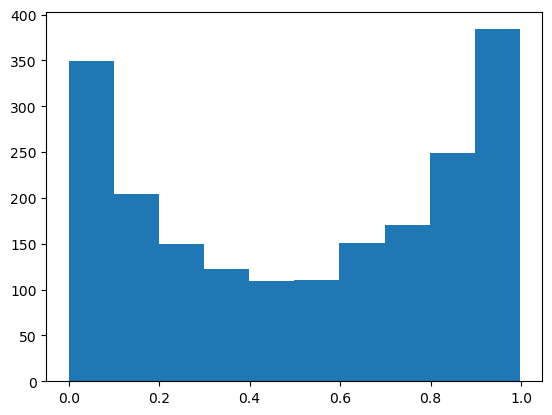

In [148]:
plt.hist(predictions_2d_df.yhat.to_numpy())
plt.show()

### Confusion matrices of train, valid and test splits 

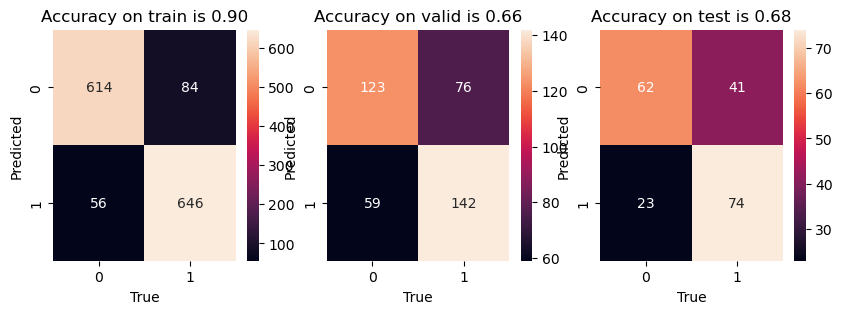

In [149]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

# make confusion matrix for each split
splits = ['train','valid','test']
fig, axes = plt.subplots(nrows=1,ncols=len(splits),figsize=(10, 3), dpi=100)

for i,split in enumerate(splits):
    
    y_true = predictions_2d_df[predictions_2d_df['split']==split]['y'].to_numpy()
    y_pred = predictions_2d_df[predictions_2d_df['split']==split]['yhat'].to_numpy()
    y_pred = np.round(y_pred) #get to crisp binary class labels from posterior probability

    # Computer confusion matrix
    cm = confusion_matrix(y_true, y_pred)    
    score = accuracy_score(y_true,y_pred) #compute accuracy score
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm_df, annot=True, fmt='d',ax = axes[i])
    axes[i].set_title(f'Accuracy on {split} is {score:.2f}')
    axes[i].set_xlabel('True')
    axes[i].set_ylabel('Predicted')

plt.show()



## 5.4 Train a classification model based on 3D images

### Configure the 5 yamls and run the training

In [150]:
run_name = f"some_3d_run_{now_str()}"

!serotiny train \
    model=example_classifier_3d \
    data=example_dataloader_3d \
    mlflow=internal_mlflow \
    mlflow.experiment_name=cytodata_chapter5 \
    mlflow.run_name={run_name} \
    trainer.gpus=[0] \
    trainer.max_epochs=25 

[2022-09-21 14:29:30,938][torch.distributed.nn.jit.instantiator][INFO] - Created a temporary directory at /tmp/tmppbfow4el
[2022-09-21 14:29:30,938][torch.distributed.nn.jit.instantiator][INFO] - Writing /tmp/tmppbfow4el/_remote_module_non_scriptable.py
[2022-09-21 14:29:31,072][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-09-21 14:29:31,073][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-09-21 14:29:31,862][bfio.backends][WARNING] - Java backend is not available. This could be due to a missing dependency (jpype).
[2022-09-21 14:29:32,259][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
[2022-09-21 14:29:32,890][pytorch_lightning.utilities.rank

Note: The above task takes more the 16GB (it will not fit on the AWS computers) 45618MiB / 81920MiB

### Make predictions from the pretrained model

In [160]:
!serotiny predict \
    model=example_classifier_3d \
    data=example_dataloader_3d \
    mlflow=internal_mlflow \
    mlflow.experiment_name=cytodata_chapter5 \
    mlflow.run_name={run_name} \
    trainer.gpus=[0]

[2022-09-21 17:10:35,574][torch.distributed.nn.jit.instantiator][INFO] - Created a temporary directory at /tmp/tmpkxe5ago0
[2022-09-21 17:10:35,574][torch.distributed.nn.jit.instantiator][INFO] - Writing /tmp/tmpkxe5ago0/_remote_module_non_scriptable.py
[2022-09-21 17:10:35,710][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-09-21 17:10:35,710][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-09-21 17:10:36,523][bfio.backends][WARNING] - Java backend is not available. This could be due to a missing dependency (jpype).
[2022-09-21 17:10:36,912][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
[2022-09-21 17:10:37,498][pytorch_lightning.utilities.rank

### Retrieving predictions from MLFlow

In [162]:
mlflow.set_tracking_uri("https://mlflow.a100.int.allencell.org")

with download_artifact("predictions/model_predictions.csv", experiment_name="cytodata_chapter5", run_name=run_name) as path:
    predictions_3d_df = pd.read_csv(path)

In [167]:
predictions_3d_df = predictions_3d_df.merge(cells_edgeVSnoedge[['CellId','split']].rename(columns={'CellId':'id'}), on = 'id')
predictions_3d_df
# print(len(predictions_3d_df))

,id,y,yhat,loss,split
0,801298,0.0,0.000011,0.263160,test
1,801507,0.0,0.042444,0.263160,test
2,457583,0.0,0.999929,0.263160,train
3,464188,0.0,0.328313,0.263160,train
4,710101,0.0,0.002056,0.263160,train
...,...,...,...,...,...
1995,956830,1.0,0.999865,0.412224,test
1996,392798,1.0,0.999739,0.412224,train
1997,553631,1.0,0.999976,0.412224,train
1998,549101,1.0,0.009920,0.412224,train


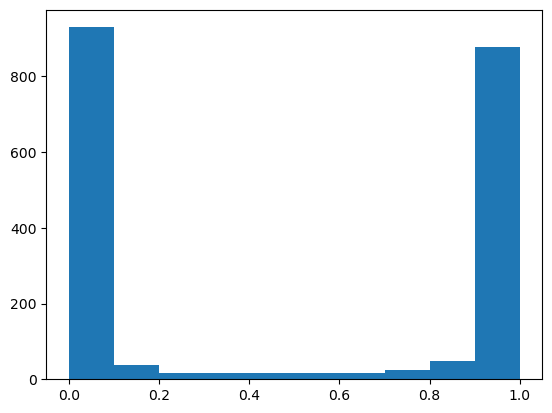

In [168]:
plt.hist(predictions_3d_df.yhat.to_numpy())
plt.show()

### Confusion matrices of train, valid and test splits 

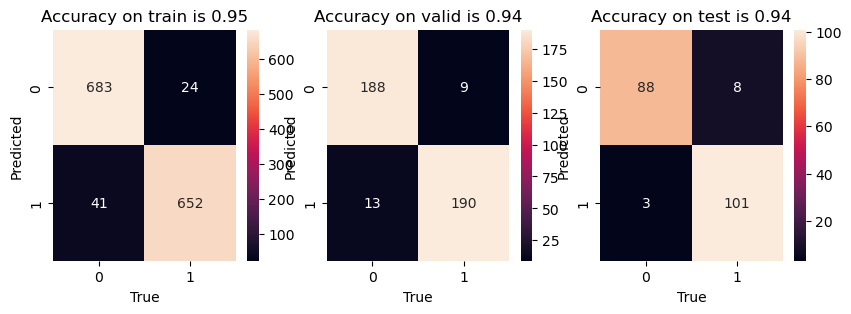

In [169]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

# make confusion matrix for each split
splits = ['train','valid','test']
fig, axes = plt.subplots(nrows=1,ncols=len(splits),figsize=(10, 3), dpi=100)

for i,split in enumerate(splits):
    
    y_true = predictions_3d_df[predictions_3d_df['split']==split]['y'].to_numpy()
    y_pred = predictions_3d_df[predictions_3d_df['split']==split]['yhat'].to_numpy()
    y_pred = np.round(y_pred) #get to crisp binary class labels from posterior probability

    # Computer confusion matrix
    cm = confusion_matrix(y_true, y_pred)    
    score = accuracy_score(y_true,y_pred) #compute accuracy score
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm_df, annot=True, fmt='d',ax = axes[i])
    axes[i].set_title(f'Accuracy on {split} is {score:.2f}')
    axes[i].set_xlabel('True')
    axes[i].set_ylabel('Predicted')

plt.show()

